<a href="https://colab.research.google.com/github/LueMar-R/P35_Traitement_Caryotypes/blob/main/Classification_chromosomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification de Chromosomes

<hr>

- <a href='#3'>Préparation des données</a>
- <a href='#4'>Entrainement du modèle de reconnaissance des chromosomes</a>
- <a href='#5'>Résultats</a> 

<hr>

In [2]:
#préparation des imports (bibliothèques et librairies nécéssaires à l'éxécution du code)
import os
import sys
import numpy as np
import time
import cv2
import pickle

from glob import glob

from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from keras import Sequential
from tensorflow.keras.utils import to_categorical

### <a id='1'>Prévisualisation des données</a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/P35_Segmentation_chromosomes'

/content/drive/MyDrive/P35_Segmentation_chromosomes


In [5]:
!unzip data/chro.zip

Archive:  data/chro.zip
replace labels.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: labels.npy              
  inflating: X_mono.npy              


In [6]:
%ls

base_donnees.zip         labels.npy                  O201618.011.A.TIF
chromosom_classifier_1/  Notes_chromosomes_seg.gdoc  o201632.009.A.TIF
chromosom_classifier_2/  O201577.017.A.TIF           X_mono.npy
cmat.png                 O201583.014.A.TIF
data/                    O201606.003.A.TIF


In [30]:
#nous accédons aux données depuis le dossier dans lequel elles sont stockées
with open('X_mono.npy', 'rb') as f: 
    X = np.load(f )
with open('labels.npy', 'rb') as f: 
    Y = np.load(f )

print("nombre d'images/labels :",len(X), len(Y))

NUM_CLASS = len(np.unique(Y))
print("nombre de classes :", NUM_CLASS)

print("taille des images :", X[0].shape)

print("nombre d'image de chaque classe :")
unique, counts = np.unique(Y, return_counts=True)
distrib = dict(zip(unique, counts))
print(distrib)

nombre d'images/labels : 8441 8441
nombre de classes : 24
taille des images : (128, 128)
nombre d'image de chaque classe :
{0: 379, 1: 364, 2: 386, 3: 365, 4: 365, 5: 374, 6: 364, 7: 364, 8: 372, 9: 365, 10: 366, 11: 365, 12: 364, 13: 363, 14: 365, 15: 366, 16: 364, 17: 364, 18: 365, 19: 364, 20: 366, 21: 368, 22: 280, 23: 83}


In [31]:
LABELS = {0: "c1", 1: "c2", 2: "c3", 3: "c4", 4: "c5", 5: "c6", 6: "c7", 
          7: "c8", 8: "c9", 9: "c10", 10: "c11", 11: "c12", 12: "c13", 
          13: "c14", 14: "c15", 15: "c16", 16: "c17", 17: "c18", 18: "c19", 
          19: "c20", 20: "c21", 21:"c22", 22: "cX", 23: "cY"}

### <a id='3'>Préparation des données</a>

###### Chargement des données

Il y a 8441 images de (128, 128) pixels dans le dataset. 
Voici par exemple l'image n°42 :


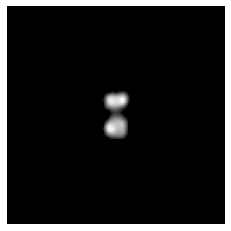

In [32]:
plt.imshow(X[42], cmap="gray")
plt.axis("off")
print(f"Il y a {len(X)} images de {X[42].shape} pixels dans le dataset.\
 \nVoici par exemple l'image n°42 :")

###### Mélange des données

In [33]:
# mélange des données
index = np.random.permutation([i for i in range(len(X))])

X = np.asarray(X, dtype=np.uint8)[index]
Y = np.asarray(Y, dtype=np.uint8)[index]

print(X.shape)
print(Y.shape)

(8441, 128, 128)
(8441,)


In [34]:
# séparation
valsplit = len(X)//5*4
X_train = X[:valsplit]
y_train = Y[:valsplit]
X_test = X[valsplit:]
y_test = Y[valsplit:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6752, 128, 128) (6752,)
(1689, 128, 128) (1689,)


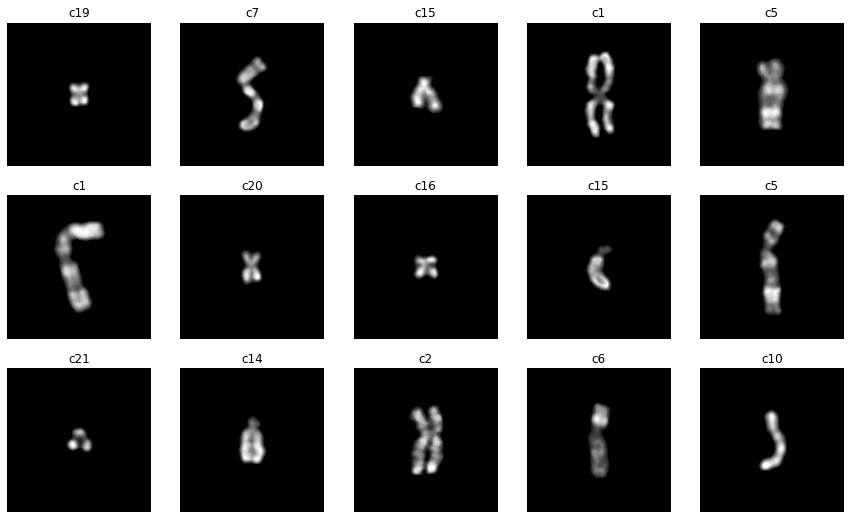

In [35]:
# visualisation
plt.figure(figsize=(15,9))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow((X_train[i]), cmap='gray')
    plt.title(LABELS[y_train[i]])
    plt.axis('off')
plt.show()

###### Prétraitement en vue de l'entraînement avec un CNN Séquentiel 

In [36]:
print(np.max(X_train), np.min(X_train)) # standardisation nécessaire

255 0


In [37]:
# standardisation, redimensionnement des features
X_train = X_train / 255.
X_test = X_test / 255.
# ajout d'une dimension batch
X_train = np.expand_dims(X_train,3)
X_test = np.expand_dims(X_test,3)

In [38]:
# encodage de la target
Y_train = to_categorical(y_train, num_classes=NUM_CLASS)
Y_test = to_categorical(y_test, num_classes=NUM_CLASS)


In [39]:
# vérificationpour un élément au hasard du set d'entrainement
print(Y_train[42], y_train[42], LABELS[y_train[42]]) 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 21 c22


In [40]:
# vérificationpour un élément au hasard du set de test
print(Y_test[42], y_test[42], LABELS[y_test[42]]) #test

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10 c11


### <a id='4'>Entrainement du modèle de reconnaissance des chromosomes</a>

###### Création du modèle séquentiel

In [ ]:
modelX = models.Sequential()

modelX.add(Conv2D(64, 7, padding="same", activation='relu', input_shape=(128,128,1)))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(64, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(128, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Flatten())
modelX.add(Dense(64, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(32, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(NUM_CLASS, activation='softmax'))

In [ ]:
# premier entraînement avec Adamax
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = modelX.fit(X_train, Y_train, epochs=100, batch_size=10, validation_split=0.2)

Epoch 1/100
541/541 [==============================] - 44s 28ms/step - loss: 3.0102 - accuracy: 0.0959 - val_loss: 2.8322 - val_accuracy: 0.2509
Epoch 2/100
541/541 [==============================] - 14s 27ms/step - loss: 2.6327 - accuracy: 0.2014 - val_loss: 2.2704 - val_accuracy: 0.4056
Epoch 3/100
541/541 [==============================] - 14s 27ms/step - loss: 2.3409 - accuracy: 0.2799 - val_loss: 1.9842 - val_accuracy: 0.4959
Epoch 4/100
541/541 [==============================] - 15s 27ms/step - loss: 2.1132 - accuracy: 0.3509 - val_loss: 1.6728 - val_accuracy: 0.5418
Epoch 5/100
541/541 [==============================] - 14s 27ms/step - loss: 1.9558 - accuracy: 0.3973 - val_loss: 1.6057 - val_accuracy: 0.6092
Epoch 6/100
541/541 [==============================] - 14s 27ms/step - loss: 1.8213 - accuracy: 0.4321 - val_loss: 1.3655 - val_accuracy: 0.6632
Epoch 7/100
541/541 [==============================] - 15s 27ms/step - loss: 1.7394 - accuracy: 0.4601 - val_loss: 1.2902 - val_ac

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

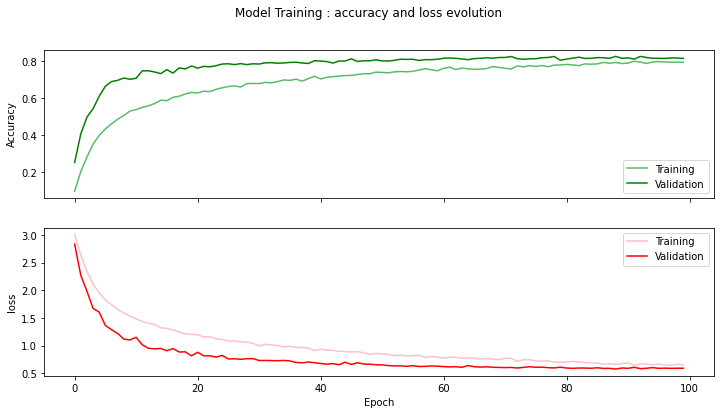

In [ ]:
x = list(range(len(loss)))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,6))
fig.suptitle('Model Training : accuracy and loss evolution')
ax1.plot(x, accuracy, color='#5aba66')
ax1.plot(x, val_accuracy, color='green')
ax1.set_ylabel('Accuracy')
ax1.legend(['Training', 'Validation'], loc='lower right')
ax2.plot(x, loss,  color='pink')
ax2.plot(x, val_loss,  color='red')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
#modelX.save('chromosom_classifier_1')

INFO:tensorflow:Assets written to: chromosom_classifier_1/assets


In [ ]:
modelX = models.load_model('chromosom_classifier_1')

In [ ]:
# second entrainement en affinant les parametres 
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.0001, beta_1=0.6, beta_2=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = modelX.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
169/169 [==============================] - 11s 62ms/step - loss: 0.6188 - accuracy: 0.8080 - val_loss: 0.5855 - val_accuracy: 0.8135
Epoch 2/10
169/169 [==============================] - 10s 61ms/step - loss: 0.6299 - accuracy: 0.8100 - val_loss: 0.5835 - val_accuracy: 0.8179
Epoch 3/10
169/169 [==============================] - 10s 61ms/step - loss: 0.6584 - accuracy: 0.7926 - val_loss: 0.5761 - val_accuracy: 0.8194
Epoch 4/10
169/169 [==============================] - 10s 61ms/step - loss: 0.6390 - accuracy: 0.8015 - val_loss: 0.5746 - val_accuracy: 0.8238
Epoch 5/10
169/169 [==============================] - 10s 61ms/step - loss: 0.6096 - accuracy: 0.8052 - val_loss: 0.5787 - val_accuracy: 0.8238
Epoch 6/10
169/169 [==============================] - 10s 61ms/step - loss: 0.6468 - accuracy: 0.7958 - val_loss: 0.5743 - val_accuracy: 0.8246
Epoch 7/10
169/169 [==============================] - 10s 61ms/step - loss: 0.6050 - accuracy: 0.8108 - val_loss: 0.5807 - val_accuracy:

In [ ]:
modelX.save('chromosom_classifier_2')

INFO:tensorflow:Assets written to: chromosom_classifier_2/assets


###### Validation sur la base de données de test

In [41]:
modelX = models.load_model('chromosom_classifier_2')

In [42]:
X_test.shape

(1689, 128, 128, 1)

In [43]:
Y_pred = modelX.predict(X_test)

In [44]:
y_pred=[]
for y in Y_pred:
    y_pred.append(np.argmax(y))

In [45]:
cf_matrix = confusion_matrix(y_test, y_pred)

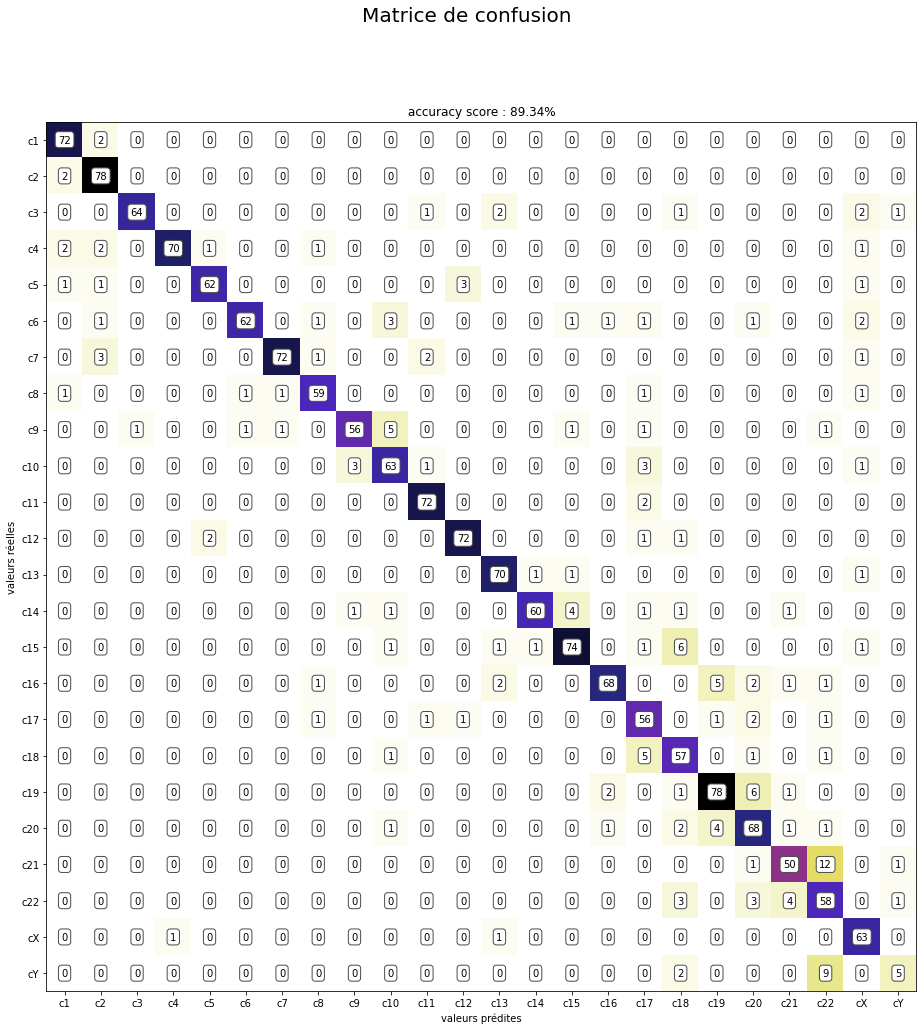

<Figure size 432x288 with 0 Axes>

In [46]:
plt.figure(figsize=(16,16))
plt.imshow(cf_matrix, cmap="CMRmap_r")
for (i, j), z in np.ndenumerate(cf_matrix):
    plt.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("valeurs prédites")
plt.xticks(ticks =[i for i in range(len(LABELS))], labels=[LABELS[i] for i in range(len(LABELS))])
plt.ylabel("valeurs réelles")
plt.yticks(ticks =[i for i in range(len(LABELS))], labels=[LABELS[i] for i in range(len(LABELS))])
plt.title(f" accuracy score : {np.round(accuracy_score(y_test, y_pred)*100,2)}% ", fontsize=12)
plt.suptitle(f"Matrice de confusion", fontsize=20)
plt.show()
plt.savefig("cmat.png")



### <a id='5'>Résultats</a>

Les chromosomes sont globalement bien reconnus et classifiés, excepté le chromosome Y.